In [1]:
import numpy as np
import pandas as pd
from mgwr.mgwr.gwr import MGWR, GWR
from mgwr.mgwr.sel_bw import Sel_BW
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt


In [2]:
train_set = pd.read_csv('../../data/train_set_with_feat.csv')
test_set = pd.read_csv('../../data/test_set_with_feat.csv')

data = pd.concat([train_set])
data.head()

,id,mean_gs,sd,skewness,kurtosis,current_max,current_mean,current_min,gebco,x,...,y_im,x_im,x_m,y_m,slope,aspect,rough,bpi,shore_dist,current_range
0,1,2.48,1.33,3.70,24.33,0.164273,0.156398,0.146120,-227,-60.09194,...,724,915,186657.194374,335813.797226,14.389555,6.513883,124,-37,212225.813617,0.018153
1,2,4.15,1.82,2.34,9.43,0.116663,0.101989,0.092233,-17,-60.05735,...,642,924,188493.166778,297779.637872,0.061764,270.000000,4,0,181851.069142,0.024430
2,3,1.79,0.98,4.16,26.64,0.116663,0.101989,0.092233,-17,-60.05735,...,642,924,188493.166778,297779.637872,0.061764,270.000000,4,0,181851.069142,0.024430
3,4,1.58,0.75,5.16,45.76,0.106330,0.091203,0.081784,-18,-60.09058,...,642,916,186861.191308,297779.637872,0.061764,270.000000,2,0,179771.101828,0.024546
4,5,0.85,1.16,1.04,15.00,0.106330,0.091203,0.081784,-18,-60.08782,...,642,916,186861.191308,297779.637872,0.061764,270.000000,2,0,179771.101828,0.024546


In [3]:
print(list(data))
posibble_preds = list(data)
items_to_remove = ['id', 'mean_gs', 'sd', 'skewness', 'kurtosis', 'current_max', 'current_min','sample_type','y_im', 'x_im', 'x_m', 'y_m', 'current_mean', 'current_range', 'gebco', 'x', 'y']
#remove "base" as well
updated_list = [item for item in posibble_preds if item not in items_to_remove]

#data['current_range'] = data['current_max'] - data['current_min']
print(updated_list)

['id', 'mean_gs', 'sd', 'skewness', 'kurtosis', 'current_max', 'current_mean', 'current_min', 'gebco', 'x', 'y', 'sample_type', 'y_im', 'x_im', 'x_m', 'y_m', 'slope', 'aspect', 'rough', 'bpi', 'shore_dist', 'current_range']
['slope', 'aspect', 'rough', 'bpi', 'shore_dist']


In [4]:

predictors = ['current_mean', 'current_range', 'gebco']
response = 'mean_gs'


In [5]:

gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['x'], data['y']))
gdf = gdf.set_crs(epsg=4326)  # Assuming WGS84
gdf = gdf.to_crs(epsg=32633)  # Convert to UTM zone 33N

data['x'] = gdf.geometry.x
data['y'] = gdf.geometry.y
print(data['x'])


0      -5.036759e+06
1      -4.986116e+06
2      -4.986116e+06
3      -4.987333e+06
4      -4.987276e+06
            ...     
2105   -5.001167e+06
2106   -4.970671e+06
2107   -4.951021e+06
2108   -4.910076e+06
2109   -4.951217e+06
Name: x, Length: 2110, dtype: float64


In [6]:

coords = data[['x', 'y']].values
X = data[predictors].values
y = data[response].values.reshape(-1, 1)


In [7]:
import itertools

combinations = []
for r in range(0, len(updated_list) + 1):
    combinations.extend(itertools.combinations(updated_list, r))

# Add each combination to A
pred_result = [predictors + list(comb) for comb in combinations]

In [ ]:
res_dict = dict()
for pred in range(len(pred_result)):
    predictorsN = pred_result[pred]
    print(predictorsN)
    X = data[predictorsN].values
    y = data[response].values.reshape(-1, 1)
    selector = Sel_BW(coords, y, X, multi=False) # This creates the bandwidths for different input features
    bws = selector.search(verbose=True, search_method='golden_section', max_iter=100) # This searches for the optimal bandwidth (fields of influence)
    mgwr_model = GWR(coords, y, X, bws)
    results = mgwr_model.fit() # This fits the model to the data
    mgwr_model = GWR(coords, y, X, bws)
    results = mgwr_model.fit() # This fits the model to the data
    res_dict[pred] = results.adj_R2

['current_mean', 'current_range', 'gebco']
Bandwidth:  836.0 , score:  9886.94
Bandwidth:  1322.0 , score:  9935.94
Bandwidth:  535.0 , score:  9832.32
Bandwidth:  349.0 , score:  9759.59
Bandwidth:  234.0 , score:  9713.81
Bandwidth:  163.0 , score:  9705.43
Bandwidth:  119.0 , score:  9720.16
Bandwidth:  190.0 , score:  9707.09
Bandwidth:  146.0 , score:  9709.61
Bandwidth:  173.0 , score:  9705.83
Bandwidth:  156.0 , score:  9707.70
Bandwidth:  167.0 , score:  9705.41
Bandwidth:  169.0 , score:  9705.82
Bandwidth:  165.0 , score:  9705.10
['current_mean', 'current_range', 'gebco', 'slope']
Bandwidth:  837.0 , score:  9865.38
Bandwidth:  1323.0 , score:  9913.94
Bandwidth:  536.0 , score:  9816.82
Bandwidth:  351.0 , score:  9748.08
Bandwidth:  236.0 , score:  9715.72
Bandwidth:  165.0 , score:  9711.68
Bandwidth:  121.0 , score:  9729.90
Bandwidth:  192.0 , score:  9714.49
Bandwidth:  148.0 , score:  9717.85
Bandwidth:  175.0 , score:  9711.21
Bandwidth:  182.0 , score:  9712.54
Ban

In [9]:
print(data[predictorsN].describe())
print(data[response].isnull().any())
print(data[response].describe())

       current_mean  current_range        gebco        slope       aspect  \
count   2110.000000    2110.000000  2110.000000  2110.000000  2110.000000   
mean       0.127527       0.040447  -138.507583     4.399319   200.141569   
std        0.120497       0.031617   257.019405    16.328842   105.480069   
min        0.010597       0.002052 -2678.000000     0.000000     0.000000   
25%        0.073492       0.019161  -151.000000     0.232494   127.158690   
50%        0.102969       0.031267  -101.000000     0.488382   199.143023   
75%        0.129335       0.053444   -34.000000     1.539838   294.453350   
max        1.354895       0.263713     7.000000    89.346970   359.236434   

             rough          bpi     shore_dist  
count  2110.000000  2110.000000    2110.000000  
mean     16.866825    -0.059242  119698.001625  
std      25.723017     4.221218   73026.410576  
min       0.000000   -39.000000     463.312194  
25%       3.000000     0.000000   52834.720859  
50%       7.

In [15]:
for j in res_dict:
    print(j)
    print(res_dict[j])



0
0.3319303442495988
1
0.3356275387312322
2
0.3247250376940888
3
0.3318631552771998
4
0.3269359996241842
5
0.3389299497336189
6
0.32933293081492054
7
0.3460005918546992
8
0.3319599486639825
9
0.33825676727891096
10
0.3276903499514463
11
0.3297588025499645
12
0.33296858778397875
13
0.3328043022657208
14
0.34145466710648564
15
0.33398574111754087
16
0.3363656922241546
17
0.33092143912970307
18
0.33244204031046953
19
0.3371075208611143
20
0.34701015398906965
21
0.3352024685752836
22
0.3343464141830308
23
0.33501055867385576
24
0.33267047659212634
25
0.33533559222480525
26
0.3398133501231261
27
0.34527243511971406
28
0.33788768311745054
29
0.34189210415189286
30
0.3348242530099397
31
0.3367704660173727


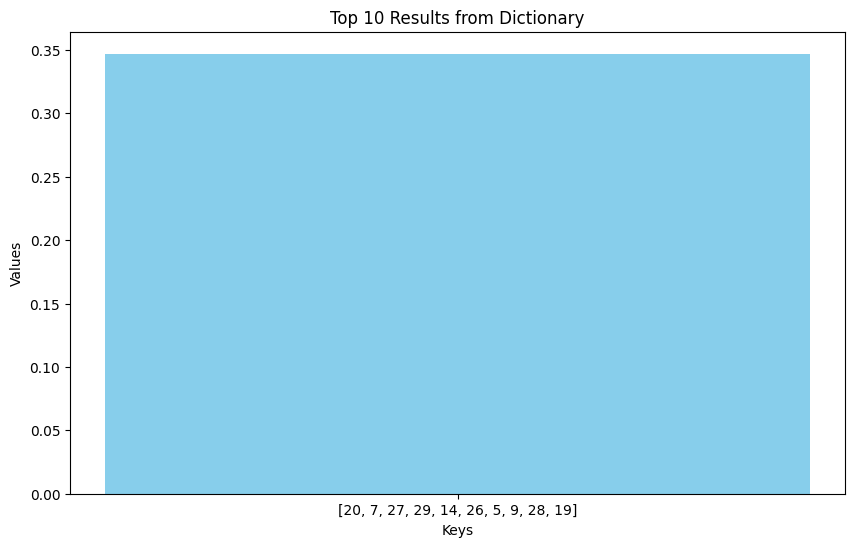

In [ ]:
results = res_dict
# Number of top results to show
x = 10

# Sort the dictionary by values in descending order and get the top `x` results
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True)[:x])


# Extract keys and values from the sorted dictionary
keys = (list(str(sorted_results.keys())))
values = list(sorted_results.values())

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title(f'Top {x} Results from Dictionary')
plt.show()


In [11]:

mgwr_model = GWR(coords, y, X, bws)
results = mgwr_model.fit() # This fits the model to the data
print(results.summary()) # This prints the summary of the model fit


Model type                                                         Gaussian
Number of observations:                                                2110
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          14701.302
Log-likelihood:                                                   -5041.977
AIC:                                                              10101.954
AICc:                                                             10104.059
BIC:                                                              -1380.683
R2:                                                                   0.153
Adj. R2:                                                              0.150

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [12]:
print(results.summary())

Model type                                                         Gaussian
Number of observations:                                                2110
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          14701.302
Log-likelihood:                                                   -5041.977
AIC:                                                              10101.954
AICc:                                                             10104.059
BIC:                                                              -1380.683
R2:                                                                   0.153
Adj. R2:                                                              0.150

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [13]:

test_data = pd.read_csv('test_set_real.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'test_set_real.csv'

In [ ]:

test_gdf = gpd.GeoDataFrame(test_data, geometry=gpd.points_from_xy(test_data['x'], test_data['y']))
test_gdf = test_gdf.set_crs(epsg=4326)
test_gdf = test_gdf.to_crs(epsg=32633)

test_data['x'] = test_gdf.geometry.x
test_data['y'] = test_gdf.geometry.y


In [ ]:

#test_data['current_range'] = test_data['current_max'] - test_data['current_min']


In [ ]:

test_coords = test_data[['x', 'y']].values
test_X = test_data[predictors].values


In [ ]:
scale = results.scale
residuals = results.resid_response
test_data['mean_gs'] = mgwr_model.predict(test_coords, test_X, scale, residuals).predictions # This predicts the response variable for the test data using the fitted model


In [ ]:

submission = test_data[['id', 'mean_gs']]
submission.to_csv('test_submission_mgwr.csv', index=False)
